## 1. 환경 설정

`(1) LangSmith 설정 확인`
- .env 파일에 아래 내용을 반영
    - LANGCHAIN_TRACING_V2=true  
    - LANGCHAIN_ENDPOINT="https://api.smith.langchain.com"  
    - LANGCHAIN_API_KEY="인증키를 입력하세요"  
    - LANGCHAIN_PROJECT="프로젝트명"  

`(2) 기본 라이브러리`

In [10]:
import os
from glob import glob

from pprint import pprint
import json

import numpy as np
import pandas as pd

`(3) Env 환경변수`

In [11]:
from dotenv import load_dotenv
load_dotenv()

# Langsmith tracing 여부를 확인 (true: langsmith 추적 활성화, false: langsmith 추적 비활성화)
print("langsmith 추적 여부: ", os.getenv('LANGCHAIN_TRACING_V2'))

langsmith 추적 여부:  None


## 2.  벡터저장소 로드

In [1]:
# 벡터스토어 로드
from langchain_community.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings

embeddins_model = HuggingFaceEmbeddings(model_name = "BAAI/bge-m3")

chroma_db = Chroma(
    embedding_function=embeddins_model,
    collection_name="hf_bge_m3",
    persist_directory="./chroma_db"
)

c:\Users\1\miniconda3\envs\langchain\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
C:\Users\1\AppData\Local\Temp\ipykernel_20024\2353339637.py:7: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the langchain-chroma package and should be used instead. To use it run `pip install -U langchain-chroma` and import as `from langchain_chroma import Chroma`.
  chroma_db = Chroma(
Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [2]:
# 기본 retriever 초기화
chroma_k_retriever = chroma_db.as_retriever(
    search_kwargs={"k":2}
)

query = "리비안의 성장 동력은 무엇인가요?"
retrieved_docs = chroma_k_retriever.invoke(query)

print(f"쿼리: {query}")
print("검색 결과:")
for doc in retrieved_docs:
    print(f"- {doc.page_content} [출처: {doc.metadata['source']}]")
    print("-"*100)
    print()

Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


쿼리: 리비안의 성장 동력은 무엇인가요?
검색 결과:
- 리비안은 MIT 박사 출신 RJ 스카린지가 2009년에 설립한 혁신적인 미국 전기차 제조업체입니다. 2011년부터 자율 전기차에 집중한 리비안은 2015년 대규모 투자를 통해 크게 성장하며 미시간과 베이 지역에 연구소를 설립했습니다. 주요 공급업체와의 접근성을 높이기 위해 본사를 미시간주 리보니아로 이전했습니다

(참고: 이 문서는 리비안에 대한 정보를 담고 있습니다.) [출처: 리비안_KR.txt]
----------------------------------------------------------------------------------------------------

- .

리비안의 초기 모델은 스포츠카 R1(원래 이름은 Avera)로, 2+2 좌석의 미드 엔진 하이브리드 쿠페로 피터 스티븐스가 디자인했습니다. 이 차는 쉽게 교체 가능한 본체 패널을 갖춘 모듈식 캡슐 구조를 특징으로 하며, 2013년 말에서 2014년 초 사이에 생산이 예상되었습니다

(참고: 이 문서는 리비안에 대한 정보를 담고 있습니다.) [출처: 리비안_KR.txt]
----------------------------------------------------------------------------------------------------



## 3. 고급 검색기법

### 3-1. 쿼리(Query) 확장

`(1) Multi Query`
1. Retriever에 쿼리를 생성할 LLM을 지정
1. LLM이 다양한 관점에서 여러 개의 쿼리를 생성

- MultiQueryRetriever 활용

In [4]:
# 멀티 쿼리 생성
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain_openai import ChatOpenAI


llm = ChatOpenAI(
    model='gpt-4o-mini',
    temperature=0.7,
    max_tokens=100,
)


# 기본 retriever를 이용한 멀티 쿼리 생성 
multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=chroma_k_retriever, llm=llm
)

query = "리비안의 성장 동력은 무엇인가요?"
retrieved_docs = multi_query_retriever.invoke(query)

print(f"쿼리: {query}")
print("검색 결과:")
for doc in retrieved_docs:
    print(f"- {doc.page_content} [출처: {doc.metadata['source']}]")
    print("-"*100)
    print()


쿼리: 리비안의 성장 동력은 무엇인가요?
검색 결과:
- 리비안은 MIT 박사 출신 RJ 스카린지가 2009년에 설립한 혁신적인 미국 전기차 제조업체입니다. 2011년부터 자율 전기차에 집중한 리비안은 2015년 대규모 투자를 통해 크게 성장하며 미시간과 베이 지역에 연구소를 설립했습니다. 주요 공급업체와의 접근성을 높이기 위해 본사를 미시간주 리보니아로 이전했습니다

(참고: 이 문서는 리비안에 대한 정보를 담고 있습니다.) [출처: 리비안_KR.txt]
----------------------------------------------------------------------------------------------------

- .

리비안의 초기 모델은 스포츠카 R1(원래 이름은 Avera)로, 2+2 좌석의 미드 엔진 하이브리드 쿠페로 피터 스티븐스가 디자인했습니다. 이 차는 쉽게 교체 가능한 본체 패널을 갖춘 모듈식 캡슐 구조를 특징으로 하며, 2013년 말에서 2014년 초 사이에 생산이 예상되었습니다

(참고: 이 문서는 리비안에 대한 정보를 담고 있습니다.) [출처: 리비안_KR.txt]
----------------------------------------------------------------------------------------------------



- Custom Prompt 활용  

In [5]:
from typing import List

from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain_core.output_parsers import BaseOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI


# 모델 초기화
llm = ChatOpenAI(model="gpt-4o-mini")

# 출력 파서: LLM 결과를 질문 리스트로 변환
class LineListOutputParser(BaseOutputParser[List[str]]):
    """Output parser for a list of lines."""

    def parse(self, text: str) -> List[str]:
        """Split the text into lines and remove empty lines."""
        return [line.strip() for line in text.strip().split("\n") if line.strip()]
    

# 쿼리 생성 프롬프트
QUERY_PROMPT = PromptTemplate(
    input_variables=["question"],
    template="""Generate three different versions of the given user question to retrieve relevant documents from a vector database. The goal is to reframe the question from various perspectives to overcome limitations of distance-based similarity search.

    The generated questions should have the following characteristics:
    1. Maintain the core intent of the original question but use different expressions or viewpoints.
    2. Include synonyms or related concepts where possible.
    3. Slightly broaden or narrow the scope of the question to potentially include diverse relevant information.

    Write each question on a new line and include only the questions.

    [Original question]
    {question}
    
    [Alternative questions]
    """,
)


# 멀티쿼리 체인 구성
multiquery_chain = QUERY_PROMPT | llm | LineListOutputParser()

# 테스트 쿼리 실행
query = "리비안의 성장 동력은 무엇인가요?"
result = multiquery_chain.invoke({"question": query})

print("생성된 대안 질문들:")
for i, q in enumerate(result, 1):
    print(f"{i}. {q}")

생성된 대안 질문들:
1. 리비안의 발전을 이끄는 주요 요인은 무엇인가요?
2. 리비안의 성공을 촉진하는 요소들은 어떤 것들이 있나요?
3. 리비안의 성장을 위한 핵심 원동력은 무엇인지 알고 싶습니다.


In [6]:
# 다중 쿼리 검색기 생성
multi_query_custom_retriever = MultiQueryRetriever(
    retriever=chroma_k_retriever, # 기본 retriever
    llm_chain=multiquery_chain,   # 멀티쿼리 체인
    parser_key="lines"            # "lines": 출력 파서의 키
)  

retrieved_docs = multi_query_custom_retriever.invoke(query)

print(f"쿼리: {query}")
print("검색 결과:")
for doc in retrieved_docs:
    print(f"- {doc.page_content} [출처: {doc.metadata['source']}]")
    print("-"*100)
    print()

쿼리: 리비안의 성장 동력은 무엇인가요?
검색 결과:
- 리비안은 MIT 박사 출신 RJ 스카린지가 2009년에 설립한 혁신적인 미국 전기차 제조업체입니다. 2011년부터 자율 전기차에 집중한 리비안은 2015년 대규모 투자를 통해 크게 성장하며 미시간과 베이 지역에 연구소를 설립했습니다. 주요 공급업체와의 접근성을 높이기 위해 본사를 미시간주 리보니아로 이전했습니다

(참고: 이 문서는 리비안에 대한 정보를 담고 있습니다.) [출처: 리비안_KR.txt]
----------------------------------------------------------------------------------------------------

- .

리비안의 초기 모델은 스포츠카 R1(원래 이름은 Avera)로, 2+2 좌석의 미드 엔진 하이브리드 쿠페로 피터 스티븐스가 디자인했습니다. 이 차는 쉽게 교체 가능한 본체 패널을 갖춘 모듈식 캡슐 구조를 특징으로 하며, 2013년 말에서 2014년 초 사이에 생산이 예상되었습니다

(참고: 이 문서는 리비안에 대한 정보를 담고 있습니다.) [출처: 리비안_KR.txt]
----------------------------------------------------------------------------------------------------

- .

리비안은 2021년 10월 첫 번째 양산 차량인 R1T 트럭을 고객에게 인도하기 시작했습니다.

(참고: 이 문서는 리비안에 대한 정보를 담고 있습니다.) [출처: 리비안_KR.txt]
----------------------------------------------------------------------------------------------------



`(2) Decomposition`
  
1. 입력된 질문을 여러 개의 하위 질문 또는 하위 문제로 분해 (LEAST-TO-MOST PROMPTING)  

In [7]:
from langchain.prompts import PromptTemplate
QUERY_PROMPT = PromptTemplate(
    input_variables=["question"],
    template="""You are an AI language model assistant. Your task is to decompose the given input question into multiple sub-questions. 
    The goal is to break down the input into a set of sub-problems/sub-questions that can be answered independently.

    Follow these guidelines to generate the sub-questions:
    1. Cover various aspects related to the core topic of the original question.
    2. Each sub-question should be specific, clear, and answerable independently.
    3. Ensure that the sub-questions collectively address all important aspects of the original question.
    4. Consider temporal aspects (past, present, future) where applicable.
    5. Formulate the questions in a direct and concise manner.

    [Input question] 
    {question}

    [Sub-questions (5)]
    """,
)

# 쿼리 생성 체인
decomposition_chain = QUERY_PROMPT | llm | LineListOutputParser()

# 테스트 쿼리 실행
query = "리비안의 성장 동력은 무엇인가요?"
result = decomposition_chain.invoke({"question": query})

print("생성된 서브 질문들:")
for i, q in enumerate(result, 1):
    print(f"{i}. {q}")

생성된 서브 질문들:
1. 1. 리비안의 주요 제품과 서비스는 무엇인가요?
2. 2. 리비안의 시장 점유율과 경쟁사와의 비교는 어떻게 이루어지고 있나요?
3. 3. 리비안의 성장에 기여하는 기술적 혁신은 무엇인가요?
4. 4. 리비안의 투자 및 재정 지원 현황은 어떠한가요?
5. 5. 리비안의 향후 성장 전략과 목표는 무엇인가요?


In [8]:
# 다중 쿼리 검색기 생성
multi_query_decompostion_retriever = MultiQueryRetriever(
    retriever=chroma_k_retriever,    # 기본 retriever
    llm_chain=decomposition_chain,   # 서브 질문 생성 체인
    parser_key="lines"               # "lines": 출력 파서의 키
)  

retrieved_docs = multi_query_decompostion_retriever.invoke(query)

print(f"쿼리: {query}")
print("검색 결과:")
for doc in retrieved_docs:
    print(f"- {doc.page_content} [출처: {doc.metadata['source']}]")
    print("-"*100)
    print()

쿼리: 리비안의 성장 동력은 무엇인가요?
검색 결과:
- 리비안은 MIT 박사 출신 RJ 스카린지가 2009년에 설립한 혁신적인 미국 전기차 제조업체입니다. 2011년부터 자율 전기차에 집중한 리비안은 2015년 대규모 투자를 통해 크게 성장하며 미시간과 베이 지역에 연구소를 설립했습니다. 주요 공급업체와의 접근성을 높이기 위해 본사를 미시간주 리보니아로 이전했습니다

(참고: 이 문서는 리비안에 대한 정보를 담고 있습니다.) [출처: 리비안_KR.txt]
----------------------------------------------------------------------------------------------------

- .

리비안은 2021년 10월 첫 번째 양산 차량인 R1T 트럭을 고객에게 인도하기 시작했습니다.

(참고: 이 문서는 리비안에 대한 정보를 담고 있습니다.) [출처: 리비안_KR.txt]
----------------------------------------------------------------------------------------------------

- .

리비안의 초기 모델은 스포츠카 R1(원래 이름은 Avera)로, 2+2 좌석의 미드 엔진 하이브리드 쿠페로 피터 스티븐스가 디자인했습니다. 이 차는 쉽게 교체 가능한 본체 패널을 갖춘 모듈식 캡슐 구조를 특징으로 하며, 2013년 말에서 2014년 초 사이에 생산이 예상되었습니다

(참고: 이 문서는 리비안에 대한 정보를 담고 있습니다.) [출처: 리비안_KR.txt]
----------------------------------------------------------------------------------------------------



`(3) 검색 성능 평가`

In [12]:
# 테스트 데이터셋 로드

df_qa_test = pd.read_excel("./data/qa_test_revised.xlsx")
df_qa_test.head(2)

,context,source,doc_id,question,answer
0,"['.\n\n리비안의 초기 모델은 스포츠카 R1(원래 이름은 Avera)로, 2+2...",['data/리비안_KR.txt'],['0'],리비안의 초기 모델은 무엇인가요?,리비안의 초기 모델은 스포츠카 R1입니다.
1,"['.\n\n리비안의 초기 모델은 스포츠카 R1(원래 이름은 Avera)로, 2+2...",['data/리비안_KR.txt'],['0'],R1의 좌석 구성은 어떻게 되나요?,R1은 2+2 좌석 구성입니다.


In [11]:
chroma_k_retriever.search_kwargs

{'k': 2}

In [13]:
# 평가지표 계산
from krag.utils import evaluate_retrieval_at_K

retrievers = {
    'top_k': chroma_k_retriever,
    'multy_query': multi_query_retriever,
    'multy_query_custom': multi_query_custom_retriever,
    'multi_query_decompostion': multi_query_decompostion_retriever,
}

print("k:", chroma_k_retriever.search_kwargs)

df_evaluation, df_evaluation_data = evaluate_retrieval_at_K(
    df_qa_test, 
    k=chroma_k_retriever.search_kwargs['k'],  
    retrievers=retrievers, 
    ensemble=False, 
    rouge_method='rouge2', 
    threshold=0.8)

k: {'k': 2}
Evaluating retrieval performance...
ROUGE method: rouge2, threshold: 0.8, averaging method: AveragingMethod.BOTH, matching criteria: MatchingCriteria.PARTIAL
Ensemble: False, Ensemble weights: None
Number of questions: 24


Processing questions: 100%|██████████| 24/24 [07:47<00:00, 19.48s/it]

Evaluation complete.


In [14]:
# A/B 테스트 결과 출력 
df_evaluation

,hit_rate@2,mrr@2,micro_recall@2,macro_recall@2,micro_precision@2,macro_precision@2,micro_f1@2,macro_f1@2,map@2,ndcg@2
retriever,,,,,,,,,,
multi_query_decompostion,0.791667,0.708333,0.791667,0.791667,0.395833,0.395833,0.527778,0.527778,0.708333,0.937634
multy_query,0.833333,0.812500,0.833333,0.833333,0.416667,0.416667,0.555556,0.555556,0.812500,0.979057
multy_query_custom,0.875000,0.833333,0.875000,0.875000,0.437500,0.437500,0.583333,0.583333,0.833333,0.971002
top_k,0.875000,0.854167,0.875000,0.875000,0.437500,0.437500,0.583333,0.583333,0.854167,0.984033


In [14]:
df_evaluation_data

,question,retriever,hit_rate@2,mrr@2,micro_recall@2,macro_recall@2,micro_precision@2,macro_precision@2,micro_f1@2,macro_f1@2,map@2,ndcg@2
0,리비안의 초기 모델은 무엇인가요?,top_k,1.0,1.0,1.0,1.0,0.5,0.5,0.666667,0.666667,1.0,1.000000
1,리비안의 초기 모델은 무엇인가요?,multy_query,1.0,1.0,1.0,1.0,0.5,0.5,0.666667,0.666667,1.0,1.000000
2,리비안의 초기 모델은 무엇인가요?,multy_query_custom,1.0,1.0,1.0,1.0,0.5,0.5,0.666667,0.666667,1.0,1.000000
3,리비안의 초기 모델은 무엇인가요?,multi_query_decompostion,1.0,1.0,1.0,1.0,0.5,0.5,0.666667,0.666667,1.0,1.000000
4,R1의 좌석 구성은 어떻게 되나요?,top_k,1.0,1.0,1.0,1.0,0.5,0.5,0.666667,0.666667,1.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
91,리비안은 언제 첫 번째 양산 차량을 고객에게 인도했나요?,multi_query_decompostion,1.0,0.5,1.0,1.0,0.5,0.5,0.666667,0.666667,0.5,0.720253
92,R1T 트럭은 어떤 회사의 차량인가요?,top_k,1.0,1.0,1.0,1.0,0.5,0.5,0.666667,0.666667,1.0,1.000000
93,R1T 트럭은 어떤 회사의 차량인가요?,multy_query,1.0,1.0,1.0,1.0,0.5,0.5,0.666667,0.666667,1.0,1.000000
94,R1T 트럭은 어떤 회사의 차량인가요?,multy_query_custom,1.0,1.0,1.0,1.0,0.5,0.5,0.666667,0.666667,1.0,1.000000


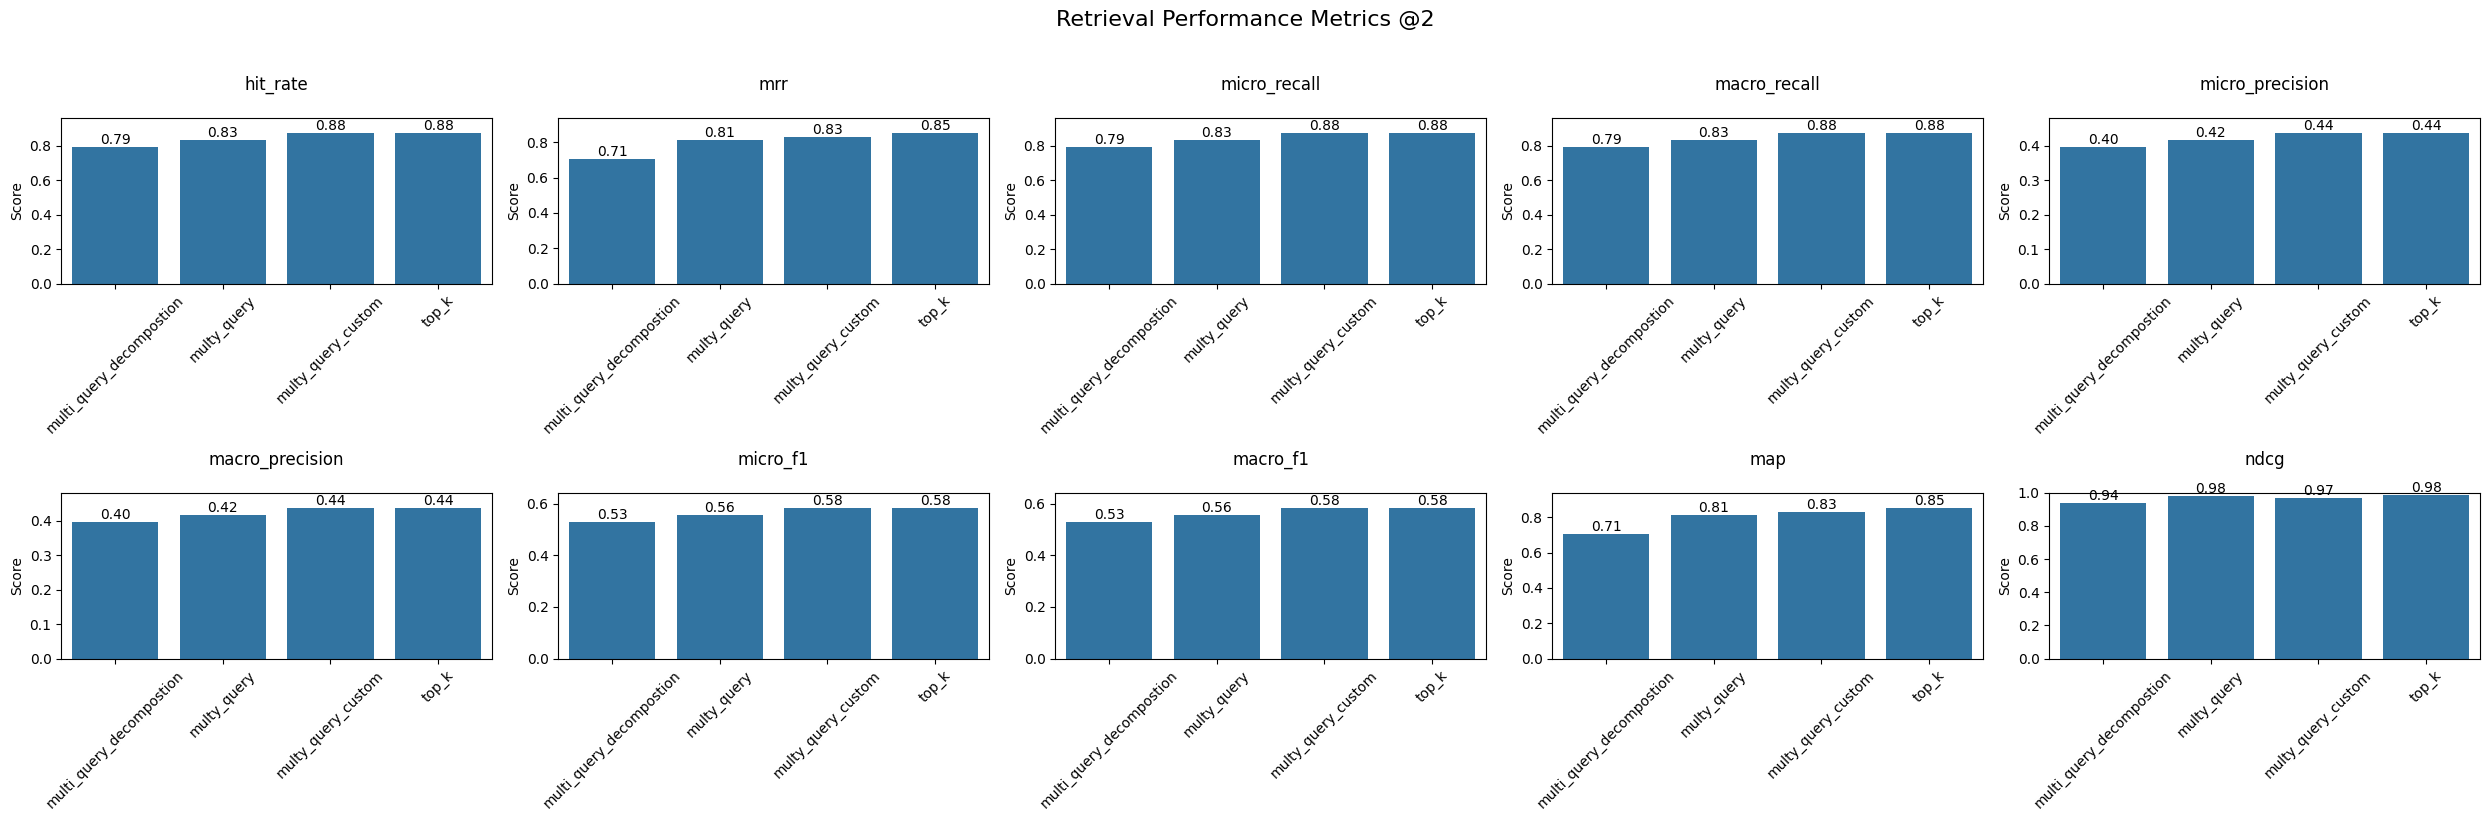

In [15]:
# A/B 테스트 결과 시각화
from krag.utils import visualize_retrieval_at_K

visualize_retrieval_at_K(df_evaluation, k=chroma_k_retriever.search_kwargs['k'])

### 3-2. Re-rank
- 재순위화는 검색 결과의 품질을 향상시키는 중요한 기법
- 사용자의 쿼리와 관련성이 큰 문서들을 추출하여 상위에 위치시키는 기법

`(1) Cross Encoder Reranker`

1. Hugging Face의 Cross-Encoder 모델을 사용하여 검색 결과를 재정렬
2. 크로스 인코더 아키텍처에서는 모델의 입력이 항상 데이터 쌍(예: 두 개의 문장 또는 문서)으로 구성되며, 이들은 인코더에 의해 공동으로 처리됨
3. 크로스 인코더는 검색 쿼리와 검색된 문서 간의 유사성을 계산  
https://www.sbert.net/examples/applications/cross-encoder/README.html

In [16]:
chroma_k_retriever.search_kwargs["k"] = 5

In [17]:
chroma_k_retriever.search_kwargs

{'k': 5}

In [18]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder

model = HuggingFaceCrossEncoder(model_name="BAAI/bge-reranker-v2-m3")
re_ranker = CrossEncoderReranker(model=model, top_n=3)

cross_encoder_reranker_retriever = ContextualCompressionRetriever(
    base_compressor=re_ranker, 
    base_retriever=chroma_k_retriever,
)

question = "테슬라 회장은 누구인가요?"

retrieved_docs = cross_encoder_reranker_retriever.invoke(question)

print(f"쿼리: {question}")
print("검색 결과:")
for doc in retrieved_docs:
    print(f"- {doc.page_content} [출처: {doc.metadata['source']}]")
    print("-"*100)
    print()

c:\Users\1\miniconda3\envs\langchain\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\1\.cache\huggingface\hub\models--BAAI--bge-reranker-v2-m3. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


쿼리: 테슬라 회장은 누구인가요?
검색 결과:
- 테슬라(Tesla, Inc.)는 텍사스주 오스틴에 본사를 둔 미국의 대표적인 전기차 제조업체입니다. 2003년 마틴 에버하드(CEO)와 마크 타페닝(CFO)에 의해 설립된 테슬라는 2004년 페이팔과 Zip2의 공동 창업자인 일론 머스크의 참여로 큰 전환점을 맞았습니다

(참고: 이 문서는 테슬라에 대한 정보를 담고 있습니다.) [출처: 테슬라_KR.txt]
----------------------------------------------------------------------------------------------------

- . 머스크는 최대 주주이자 회장으로서 회사를 현재의 성공으로 이끌었습니다. 회사 이름은 유명한 물리학자이자 전기공학자인 니콜라 테슬라의 이름을 따서 지어졌습니다. 테슬라는 2010년 6월 나스닥에 상장되었습니다

(참고: 이 문서는 테슬라에 대한 정보를 담고 있습니다.) [출처: 테슬라_KR.txt]
----------------------------------------------------------------------------------------------------

- 리비안은 MIT 박사 출신 RJ 스카린지가 2009년에 설립한 혁신적인 미국 전기차 제조업체입니다. 2011년부터 자율 전기차에 집중한 리비안은 2015년 대규모 투자를 통해 크게 성장하며 미시간과 베이 지역에 연구소를 설립했습니다. 주요 공급업체와의 접근성을 높이기 위해 본사를 미시간주 리보니아로 이전했습니다

(참고: 이 문서는 리비안에 대한 정보를 담고 있습니다.) [출처: 리비안_KR.txt]
----------------------------------------------------------------------------------------------------



`(2) LLM Reranker`  

- LLM을 사용하여 초기 검색된 문서 중에서 쿼리와 관련된 정도에 따라 순서를 조정
- 예시: LLMListwiseRerank 등 

In [ ]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMListwiseRerank
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.retrieval import create_retrieval_chain

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

re_ranker = LLMListwiseRerank.from_llm(llm, top_n=3)
llm_reranker_retriever = ContextualCompressionRetriever(
    base_compressor=re_ranker, 
    base_retriever=chroma_k_retriever,
)

question = "테슬라 회장은 누구인가요?"

# retrieved_docs = llm_reranker_retriever.invoke(question)

# print(f"쿼리: {question}")
# print("검색 결과:")
# for doc in retrieved_docs:
#     print(f"- {doc.page_content} [출처: {doc.metadata['source']}]")
#     print("-"*100)
#     print()

# prompt = ChatPromptTemplate.from_template("""
# 다음 문서를 참고하여 질문에 답하세요. 답을 모를 경우 모른다고 하세요.

# 질문: {input}
# 문서:
# {context}

# 답변:
# """)

# # 2. 문서 결합용 chain 생성 (context -> prompt -> llm -> output)
# combine_chain = create_stuff_documents_chain(llm, prompt)

# # 3. RAG 전체 체인 생성
# rag_chain = create_retrieval_chain(
#     retriever=llm_reranker_retriever,  # ContextualCompressionRetriever
#     combine_docs_chain=combine_chain
# )

# # 4. 실행
# response = rag_chain.invoke({"input": "테슬라 회장은 누구인가요?"})
# print(response["answer"])

prompt = ChatPromptTemplate.from_template("""
다음 문서를 참고하여 질문에 답하세요.
질문: {question}
문서:
{context}

답변:
""")

# 2. context chain 구성 (retriever 연결)
rag_chain = (
    {
        "context": llm_reranker_retriever | RunnablePassthrough(),  # top_n 문서 불러오기
        "question": RunnablePassthrough()
    }
    | prompt
    | llm
    | StrOutputParser()
)

# 3. 질문 실행
response = rag_chain.invoke("테슬라 회장은 누구인가요?")
print(response)

테슬라 회장은 일론 머스크입니다.


### 3-3. Contextual compression

- 맥락적 압축은 검색된 문서를 그대로 반환하는 대신, 주어진 쿼리의 맥락을 사용하여 압축하는 기법
- 쿼리와 관련된 정보만 반환되도록 하여 LLM 호출 비용을 줄이고 응답의 품질을 향상

- 구성:
    1. 기본 검색기(base retriever) 
    2. 문서 압축기(Document Compressor)


`(1) LLMChainFilter`  

- LLM을 사용하여 초기 검색된 문서 중 어떤 것을 필터링하고 어떤 것을 반환할지 결정
- 문서 내용을 압축하거나 변경하지 않음


In [23]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainFilter
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
context_filter = LLMChainFilter.from_llm(llm)

llm_filter_compression_retriever = ContextualCompressionRetriever(
    base_compressor=context_filter,             # LLM 기반 압축기
    base_retriever=chroma_db.as_retriever(),          # 기본 검색기 
)


question = "테슬라 회장은 누구인가요?"

compressed_docs = llm_filter_compression_retriever.invoke(question)

print(f"쿼리: {question}")
print("검색 결과:")
for doc in compressed_docs:
    print(f"- {doc.page_content} [출처: {doc.metadata['source']}]")
    print("-"*100)
    print()

쿼리: 테슬라 회장은 누구인가요?
검색 결과:
- 테슬라(Tesla, Inc.)는 텍사스주 오스틴에 본사를 둔 미국의 대표적인 전기차 제조업체입니다. 2003년 마틴 에버하드(CEO)와 마크 타페닝(CFO)에 의해 설립된 테슬라는 2004년 페이팔과 Zip2의 공동 창업자인 일론 머스크의 참여로 큰 전환점을 맞았습니다

(참고: 이 문서는 테슬라에 대한 정보를 담고 있습니다.) [출처: data/테슬라_KR.txt]
----------------------------------------------------------------------------------------------------

- . 머스크는 최대 주주이자 회장으로서 회사를 현재의 성공으로 이끌었습니다. 회사 이름은 유명한 물리학자이자 전기공학자인 니콜라 테슬라의 이름을 따서 지어졌습니다. 테슬라는 2010년 6월 나스닥에 상장되었습니다

(참고: 이 문서는 테슬라에 대한 정보를 담고 있습니다.) [출처: data/테슬라_KR.txt]
----------------------------------------------------------------------------------------------------



`(2) LLMChainExtractor`  

- LLM을 사용하여 초기 반환된 문서를 순회하며 쿼리와 관련된 내용만 추출 요약

In [24]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
compressor = LLMChainExtractor.from_llm(llm)

llm_extractor_compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,                                    # LLM 기반 압축기
    base_retriever=cross_encoder_reranker_retriever,               # 기본 검색기 (Re-rank)
)


question = "테슬라 회장은 누구인가요?"

compressed_docs = llm_extractor_compression_retriever.invoke(question)

print(f"쿼리: {question}")
print("검색 결과:")
for doc in compressed_docs:
    print(f"- {doc.page_content} [출처: {doc.metadata['source']}]")
    print("-"*100)
    print()

쿼리: 테슬라 회장은 누구인가요?
검색 결과:
- 일론 머스크의 참여로 큰 전환점을 맞았습니다 [출처: data/테슬라_KR.txt]
----------------------------------------------------------------------------------------------------

- 머스크는 최대 주주이자 회장으로서 회사를 현재의 성공으로 이끌었습니다. [출처: data/테슬라_KR.txt]
----------------------------------------------------------------------------------------------------



`(3) EmbeddingsFilter`  

- 문서와 쿼리를 임베딩하고 쿼리와 충분히 유사한 임베딩을 가진 문서만 반환
- LLM을 사용하지 않는 방식 (LLM 호출보다 저렴하고 빠른 옵션)


In [25]:
from langchain.retrievers.document_compressors import EmbeddingsFilter

embeddings_filter = EmbeddingsFilter(embeddings=embeddings_model, similarity_threshold=0.5)

embed_filter_compression_retriever = ContextualCompressionRetriever(
    base_compressor=embeddings_filter,                             # 임베딩 기반 압축기
    base_retriever=cross_encoder_reranker_retriever,               # 기본 검색기 (Re-rank)
)


question = "테슬라 회장은 누구인가요?"

compressed_docs = embed_filter_compression_retriever.invoke(question)

print(f"쿼리: {question}")
print("검색 결과:")
for doc in compressed_docs:
    print(f"- {doc.page_content} [출처: {doc.metadata['source']}]")
    print("-"*100)
    print()


쿼리: 테슬라 회장은 누구인가요?
검색 결과:
- 테슬라(Tesla, Inc.)는 텍사스주 오스틴에 본사를 둔 미국의 대표적인 전기차 제조업체입니다. 2003년 마틴 에버하드(CEO)와 마크 타페닝(CFO)에 의해 설립된 테슬라는 2004년 페이팔과 Zip2의 공동 창업자인 일론 머스크의 참여로 큰 전환점을 맞았습니다

(참고: 이 문서는 테슬라에 대한 정보를 담고 있습니다.) [출처: data/테슬라_KR.txt]
----------------------------------------------------------------------------------------------------

- . 머스크는 최대 주주이자 회장으로서 회사를 현재의 성공으로 이끌었습니다. 회사 이름은 유명한 물리학자이자 전기공학자인 니콜라 테슬라의 이름을 따서 지어졌습니다. 테슬라는 2010년 6월 나스닥에 상장되었습니다

(참고: 이 문서는 테슬라에 대한 정보를 담고 있습니다.) [출처: data/테슬라_KR.txt]
----------------------------------------------------------------------------------------------------



`(4) DocumentCompressorPipeline`  

- 여러 압축기를 순차적으로 결합하는 방식
- BaseDocumentTransformers를 추가하여, 문서를 더 작은 조각으로 나누거나 중복 문서를 제거하는 등의 작업도 가능

In [26]:
from langchain.retrievers.document_compressors import DocumentCompressorPipeline
from langchain_community.document_transformers import EmbeddingsRedundantFilter


# 중복 문서 제거
redundant_filter = EmbeddingsRedundantFilter(embeddings=embeddings_model)

# 쿼리와 관련성이 높은 문서만 필터링
relevant_filter = EmbeddingsFilter(embeddings=embeddings_model, similarity_threshold=0.5)

# Re-ranking
re_ranker = LLMListwiseRerank.from_llm(llm, top_n=2)

pipeline_compressor = DocumentCompressorPipeline(
    transformers=[redundant_filter, relevant_filter, re_ranker]
)

pipeline_compression_retriever = ContextualCompressionRetriever(
    base_compressor=pipeline_compressor, 
    base_retriever=chroma_db.as_retriever()
)

question = "테슬라 회장은 누구인가요?"

compressed_docs = pipeline_compression_retriever.invoke(question)

print(f"쿼리: {question}")
print("검색 결과:")
for doc in compressed_docs:
    print(f"- {doc.page_content} [출처: {doc.metadata['source']}]")
    print("-"*100)
    print()

쿼리: 테슬라 회장은 누구인가요?
검색 결과:
- . 머스크는 최대 주주이자 회장으로서 회사를 현재의 성공으로 이끌었습니다. 회사 이름은 유명한 물리학자이자 전기공학자인 니콜라 테슬라의 이름을 따서 지어졌습니다. 테슬라는 2010년 6월 나스닥에 상장되었습니다

(참고: 이 문서는 테슬라에 대한 정보를 담고 있습니다.) [출처: data/테슬라_KR.txt]
----------------------------------------------------------------------------------------------------

- 테슬라(Tesla, Inc.)는 텍사스주 오스틴에 본사를 둔 미국의 대표적인 전기차 제조업체입니다. 2003년 마틴 에버하드(CEO)와 마크 타페닝(CFO)에 의해 설립된 테슬라는 2004년 페이팔과 Zip2의 공동 창업자인 일론 머스크의 참여로 큰 전환점을 맞았습니다

(참고: 이 문서는 테슬라에 대한 정보를 담고 있습니다.) [출처: data/테슬라_KR.txt]
----------------------------------------------------------------------------------------------------



## 4. 답변 생성

In [27]:
# Context 없이 사전학습된 상태에서 답변 생성
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")
llm.invoke(question)

AIMessage(content='테슬라의 회장은 일론 머스크(Elon Musk)입니다. 그는 테슬라의 CEO이자 제품 아키텍트로도 활동하고 있으며, 회사의 비전과 전략을 주도하고 있습니다. 일론 머스크는 또한 스페이스X, Neuralink, Boring Company 등 여러 다른 혁신 기업의 창립자이자 CEO로도 알려져 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 84, 'prompt_tokens': 16, 'total_tokens': 100, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_483d39d857', 'finish_reason': 'stop', 'logprobs': None}, id='run-99768b07-f466-4bd9-b9e1-8d4f46c0c7d5-0', usage_metadata={'input_tokens': 16, 'output_tokens': 84, 'total_tokens': 100})

In [28]:
# 각 쿼리에 대한 검색 결과를 한꺼번에 Context로 전달해서 답변을 생성
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

template = """Answer the following question based on this context. If the context is not relevant to the question, just answer with '답변에 필요한 근거를 찾지 못했습니다.'

[Context]
{context}

[Question]
{question}

[Answer]
"""

prompt = ChatPromptTemplate.from_template(template)

def format_docs(docs):
    return "\n\n".join([f"{doc.page_content}" for doc in docs])

rag_chain = (
    {"context": pipeline_compression_retriever | format_docs, "question": RunnablePassthrough()} 
    | prompt
    | llm
    | StrOutputParser()
)

rag_chain.invoke("테슬라 회장은 누구인가요?")

'일론 머스크입니다.'

In [29]:
rag_chain.invoke("리비안은 2011년에 어떤 차를 공개했나요?")

'리비안은 2011년에 프로토타입 해치백을 공개했습니다.'